In [1]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE= 10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections with high group sizes.
SEED=42

## Init

In [2]:
import os
import random
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

path = os.path.join( "data", "datasets", FILENAME + ".csv")
fingerprints_file = os.path.join("data", "group_similarity", f"{FILENAME}_fingerprints_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
df_file = os.path.join("data", "group_similarity", "benchmarks", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

# if FILENAME == "compounds_ms2structures":
#     supplier = SmilesMolSupplier(path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)
# elif FILENAME == "biostructures_combined":
#     supplier = SmilesMolSupplier(path, titleLine=True, nameColumn=0)

compounds = pd.read_csv(path)
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [3]:
compounds.smiles[12]

'CCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(=O)([O-])OCC[N+](C)(C)C)[C@@H](/C=C/CCCCCCCCCCCCC)O'

## Fingerprints & Similarities

In [4]:
# code taken from https://github.com/florian-huber/molecular_fingerprint_comparisons
@numba.njit
def ruzicka_similarity(A, B):
    """
    Calculate the Ruzicka similarity between two count vectors.
    
    Parameters:
    A (array-like): First count vector.
    B (array-like): Second count vector.
    
    Returns:
    float: Ruzicka similarity.
    """
    
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum


@numba.jit(nopython=True, fastmath=True, parallel=True)
def ruzicka_similarity_matrix(references: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """Returns matrix of Ruzicka similarity between all-vs-all vectors of references and queries.

    Parameters
    ----------
    references
        Reference vectors as 2D numpy array. Expects that vector_i corresponds to
        references[i, :].
    queries
        Query vectors as 2D numpy array. Expects that vector_i corresponds to
        queries[i, :].

    Returns
    -------
    scores
        Matrix of all-vs-all similarity scores. scores[i, j] will contain the score
        between the vectors references[i, :] and queries[j, :].
    """
    assert references.shape[1] == queries.shape[1], "Vector sizes do not match!"

    size1 = references.shape[0]
    size2 = queries.shape[0]
    scores = np.zeros((size1, size2)) #, dtype=np.float32)
    for i in prange(size1):
        for j in range(size2):
            scores[i, j] = ruzicka_similarity(references[i, :], queries[j, :])
    return scores


def compute_similarity_matrix(fingerprints, sim_matrix_file):
    similarities_morgan_count = ruzicka_similarity_matrix(fingerprints, fingerprints)
    np.save(sim_matrix_file, similarities_morgan_count.astype(np.float32)) # big one ~5GB
    return np.load(sim_matrix_file, mmap_mode ='r')

In [5]:
try:
    fingerprints = np.load(fingerprints_file, mmap_mode ='r')
    print(f"Found {fingerprints_file}\nLoading fingerprints.")
except FileNotFoundError:
    print(f"File not found: {fingerprints_file}\nRunning fingerprint generation.")
    # fingerprint generation
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=MORGAN_RADIUS, fpSize=FINGERPRINT_BITS)
    fingerprints = compute_fingerprints_from_smiles(compounds.smiles, fpgen, count=True, sparse=False, progress_bar=True)
    np.save(fingerprints_file, fingerprints.astype(np.float32))
    fingerprints = np.load(fingerprints_file, mmap_mode ='r')

# sim matrix generation
try:
    sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')
    print(f"Found {sim_matrix_file}\nLoading similarity matrix.")
except FileNotFoundError:
    print(f"File not found: {sim_matrix_file}\nRunning similarity computations.")
    %time
    sim_matrix = compute_similarity_matrix(fingerprints, sim_matrix_file)

print(fingerprints.shape, sim_matrix.shape)

Found data\group_similarity\compounds_ms2structures_fingerprints_morgan9_4096bits.npy
Loading fingerprints.
Found data\group_similarity\compounds_ms2structures_ruzicka_similarities_morgan9_4096bits.npy
Loading similarity matrix.
(37811, 4096) (37811, 37811)


In [6]:
sim_matrix[:10]

memmap([[1.        , 0.14035088, 0.05179283, ..., 0.13265306, 0.09448819,
         0.06993007],
        [0.14035088, 1.        , 0.03361345, ..., 0.17919075, 0.06557377,
         0.03597122],
        [0.05179283, 0.03361345, 1.        , ..., 0.04      , 0.08196721,
         0.10188679],
        ...,
        [0.04320988, 0.02515723, 0.10538117, ..., 0.01576577, 0.06289309,
         0.10082304],
        [0.05952381, 0.0738255 , 0.01863354, ..., 0.07964602, 0.05325444,
         0.02487562],
        [0.02469136, 0.01534527, 0.05526316, ..., 0.00842697, 0.02469136,
         0.04976304]], dtype=float32)

## Analogue Selection

In [7]:
def select_analogue_groups(similarity_matrix, num_queries=10, random_select=False, group_size=30, sim_range=(0.8, 0.9999), no_overlap=True, seed=42, print_mean_similarity=False):
    random.seed(seed)
    analogue_df = pd.DataFrame(columns=["query_id", "analogue_ids"])
    used_indices =[]
    used_queries = []
    
    if random_select:
        query_index = random.randint(0, len(similarity_matrix) - 1)
    else:
        query_index = 0
    
    for i in tqdm(range(len(similarity_matrix)), desc="Selecting analogue groups"):
        # Select a random query index from the similarity matrix

        while random_select and query_index in used_queries:
            query_index = random.randint(0, len(similarity_matrix) - 1)
        
        if not random_select:
            query_index = i
        
        similar_indices = np.nonzero((similarity_matrix[query_index] >= sim_range[0]) & (similarity_matrix[query_index] <= sim_range[1]))[0]
        # remove already used ids from similar_indices
        similar_indices = [idx for idx in similar_indices if idx not in used_indices]
        # check if group size is large enough
        if len(similar_indices) >= group_size:
            if print_mean_similarity:
                mean_similarity = np.mean(similarity_matrix[query_index][similar_indices])
                print(f"Index {query_index}: Found {len(similar_indices)} similar compounds with mean similarity {mean_similarity:.3f}. Picking {group_size} random matches.")
            
            random_matches = random.sample(list(similar_indices), group_size)
            random_matches.sort(key=lambda x: similarity_matrix[query_index][x], reverse=True)
            
            analogue_df.loc[len(analogue_df)] = [query_index, random_matches]

            if no_overlap:
                used_indices.append(query_index)
                used_indices.extend(random_matches)
        
        used_queries.append(query_index)
        
        if len(analogue_df) >= num_queries:
            break
        
    analogue_df.set_index("query_id", inplace=True)
    if len(analogue_df) < num_queries:
        print(f"Found only {len(analogue_df)} analogue groups for given parameters:\nnum_queries={num_queries}, random_select={random_select}, group_size={group_size}, sim_range={sim_range}, no_overlap={no_overlap}.")
    return analogue_df


def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]


def get_analogue_groups_df(df_file, num_queries, random_select, group_size, sim_range, no_overlap, seed, morgan_radius, fpSize):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nLoaded {len(analogue_df)} analogue groups.")
    except FileNotFoundError:
        print(f"File not found: {df_file}\nRunning the analogue group selection.")
        # analogue group selection
        analogue_df = select_analogue_groups(sim_matrix,
                                             num_queries=num_queries,
                                             random_select=random_select,
                                             group_size=group_size,
                                             sim_range=sim_range,
                                             no_overlap=no_overlap, 
                                             seed=seed,
                                            )#print_mean_similarity=True)
        analogue_df.to_csv(df_file)
        print(f"{len(analogue_df)} analogue groups saved to {df_file}.")
    return analogue_df

In [8]:
analogue_df = get_analogue_groups_df(df_file, NUM_QUERIES, RANDOM_SELECT, GROUP_SIZE, SIMILARITY_RANGE, NO_OVERLAP, SEED, MORGAN_RADIUS, FINGERPRINT_BITS)
len(analogue_df)

Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Loaded 1000 analogue groups.


1000

## Benchmark

In [9]:
def off_diagonal_mean(matrix):
    n = matrix.shape[0]
    # Create mask for off-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    return matrix[mask].mean()


def get_benchmark_df_file(df_file, analogue_df, morgan_radius, fpSize):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_sim= analogue_df[:1].query_sim
        group_sim=analogue_df[:1].group_sim
        sgs=analogue_df[:1].sgs
        sgs_score=analogue_df[:1].sgs_score
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        fp_function = FingerprintFunction(fingerprint="MORGAN")
        fp_function.fp_type = "count"
        fp_function.morgan_radius = morgan_radius
        fp_function.nbits = fpSize

        for query_id, row in tqdm(analogue_df.iterrows(), desc="Processing queries", total=len(analogue_df)):
            analogue_ids = [int(x) for x in row["analogue_ids"]]
            query = generate_mol(compounds.smiles[query_id])
            
            analogues = {}
            query_sims = []
            stacked_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in tqdm(analogue_ids, desc=f"Processing analogues for query {query_id}", leave=False):
                # gather ruzicka similarity of analogue vs query
                query_sims.append(sim_matrix[query_id][ref_id])
                
                # generate the reference molecule
                if ref_id in analogues:
                    ref_analogue = analogues[ref_id]
                else:
                    ref_analogue = generate_mol(compounds.smiles[ref_id])
                    analogues[ref_id] = ref_analogue
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    if probe_id in analogues:
                        probe_analogue = analogues[probe_id]
                    else:
                        probe_analogue = generate_mol(compounds.smiles[probe_id])
                        analogues[probe_id] = probe_analogue

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, fp_function)
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            # --- gather all similarity metrics ---
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            # mean of all-vs-all analogue ruzicka similarities
            fp_group_sim_matrix = ruzicka_similarity_matrix(fingerprints[analogue_ids], fingerprints[analogue_ids])
            group_sim = off_diagonal_mean(fp_group_sim_matrix)
            analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score"] = sgs_score

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [10]:
analogue_df = get_benchmark_df_file(df_file, analogue_df, MORGAN_RADIUS, FINGERPRINT_BITS)
analogue_df

Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'query_mean_weights', 'group_sim', 'sgs', 'sgs_score']
Benchmark found! Loaded benchmark for 1000 queries.


,analogue_ids,query_sim,query_mean_weights,group_sim,sgs,sgs_score
query_id,,,,,,
35713,"[23492, 6612, 788, 12150, 18256, 29122, 23200,...",0.757227,0.745032,0.651649,0.718469,0.958369
6698,"[9297, 4956, 9558, 22927, 18407, 4192, 36935, ...",0.728808,0.699278,0.741461,0.711796,0.930022
23723,"[4900, 21338, 4110, 34356, 19498, 21458, 6469,...",0.776946,0.779438,0.714194,0.768828,0.958988
23219,"[34068, 30328, 15327, 4203, 31300, 4192, 27915...",0.764761,0.690729,0.679330,0.671523,0.952904
7161,"[5401, 6018, 34482, 8816, 6420, 14039, 9393, 1...",0.752489,0.736315,0.651582,0.704055,0.949291
...,...,...,...,...,...,...
9389,"[12, 25711, 1846, 33912, 21350, 16668, 13371, ...",0.856211,0.724871,0.793353,0.725266,0.981181
34088,"[27120, 20763, 11214, 6487, 7447, 16501, 20032...",0.793224,0.760490,0.726373,0.781378,0.950357
26225,"[8055, 29135, 24062, 37303, 4502, 27413, 7567,...",0.754275,0.721508,0.703045,0.700822,0.937447


In [11]:
analogue_df

,analogue_ids,query_sim,query_mean_weights,group_sim,sgs,sgs_score
query_id,,,,,,
35713,"[23492, 6612, 788, 12150, 18256, 29122, 23200,...",0.757227,0.745032,0.651649,0.718469,0.958369
6698,"[9297, 4956, 9558, 22927, 18407, 4192, 36935, ...",0.728808,0.699278,0.741461,0.711796,0.930022
23723,"[4900, 21338, 4110, 34356, 19498, 21458, 6469,...",0.776946,0.779438,0.714194,0.768828,0.958988
23219,"[34068, 30328, 15327, 4203, 31300, 4192, 27915...",0.764761,0.690729,0.679330,0.671523,0.952904
7161,"[5401, 6018, 34482, 8816, 6420, 14039, 9393, 1...",0.752489,0.736315,0.651582,0.704055,0.949291
...,...,...,...,...,...,...
9389,"[12, 25711, 1846, 33912, 21350, 16668, 13371, ...",0.856211,0.724871,0.793353,0.725266,0.981181
34088,"[27120, 20763, 11214, 6487, 7447, 16501, 20032...",0.793224,0.760490,0.726373,0.781378,0.950357
26225,"[8055, 29135, 24062, 37303, 4502, 27413, 7567,...",0.754275,0.721508,0.703045,0.700822,0.937447


In [12]:
len(analogue_df[analogue_df.query_sim >= 0.73])

987

In [13]:
analogue_df.describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.784824,0.745276,0.735464,0.738398,0.957548
std,0.031377,0.035400,0.045664,0.031290,0.015605
min,0.716962,0.613402,0.623999,0.619026,0.896554
25%,0.761932,0.724587,0.701849,0.720571,0.948777
50%,0.781721,0.746556,0.731256,0.735877,0.957966
75%,0.803512,0.768106,0.766433,0.760394,0.966872
max,0.876133,0.852296,0.903892,0.816185,0.996199


In [14]:
analogue_df.describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.784824,0.745276,0.735464,0.738398,0.957548
std,0.031377,0.035400,0.045664,0.031290,0.015605
min,0.716962,0.613402,0.623999,0.619026,0.896554
25%,0.761932,0.724587,0.701849,0.720571,0.948777
50%,0.781721,0.746556,0.731256,0.735877,0.957966
75%,0.803512,0.768106,0.766433,0.760394,0.966872
max,0.876133,0.852296,0.903892,0.816185,0.996199


In [15]:
analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
analogue_df.sort_values("group_sim_diff", ascending=False).head()

,analogue_ids,query_sim,query_mean_weights,group_sim,sgs,sgs_score,group_sim_diff
query_id,,,,,,,
3216,"[9674, 35992, 28197, 34429, 2274, 25745, 35699...",0.804509,0.753140,0.854252,0.708190,0.954570,0.146062
24553,"[14563, 3971, 19710, 3193, 28459, 25409, 29081...",0.761172,0.769042,0.903892,0.758152,0.904190,0.145741
12883,"[9674, 28047, 35992, 5671, 1578, 36834, 28197,...",0.780408,0.764880,0.847155,0.702260,0.936931,0.144895
9674,"[12883, 4893, 26823, 25294, 5671, 34429, 36834...",0.796600,0.754618,0.829740,0.695041,0.939938,0.134699
28047,"[3216, 12883, 5671, 2274, 17007, 13876, 20237,...",0.805326,0.750402,0.837420,0.703989,0.952716,0.133431


In [16]:
analogue_df[analogue_df.group_sim_diff > 0.05].describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score,group_sim_diff
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.790169,0.748682,0.741133,0.743093,0.956302,0.072095
std,0.034318,0.038915,0.062306,0.030853,0.014821,0.018532
min,0.727803,0.613402,0.623999,0.619026,0.904190,0.050268
25%,0.764472,0.726637,0.687916,0.723959,0.948419,0.057782
50%,0.786558,0.752948,0.730073,0.742727,0.958812,0.067833
75%,0.808622,0.773852,0.792811,0.765460,0.966023,0.081193
max,0.876133,0.852296,0.903892,0.815544,0.991309,0.146062


In [17]:
xmin = min(analogue_df.sgs.min(), analogue_df.group_sim.min())
xmax = max(analogue_df.sgs.max(), analogue_df.group_sim.max())

<Axes: >

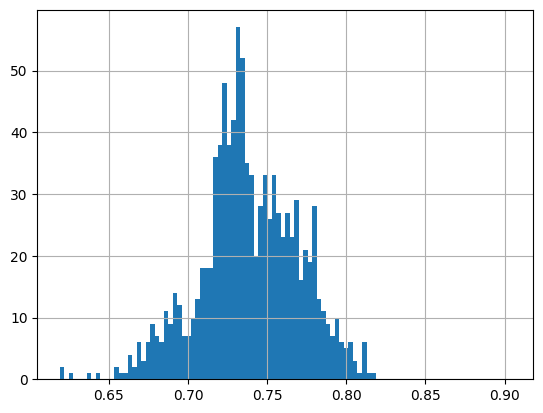

In [18]:
analogue_df.sgs.hist(bins=100, range=(xmin, xmax))

<Axes: >

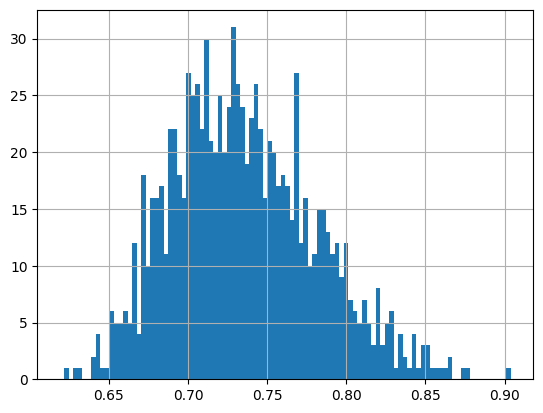

In [19]:
analogue_df.group_sim.hist(bins=100, range=(xmin, xmax))